In [270]:
## load in relevant packages
%matplotlib inline
#import seaborn as sns
import matplotlib.pyplot as plt
#plt.style.use('seaborn-whitegrid')
import pandas as pd  
import numpy as np
from scipy import linalg
import gpflow
import math as ma
from sklearn.preprocessing import StandardScaler  
feature_scaler = StandardScaler()

np.random.seed(5)

## set max number
N = 25
## set number of sensor locations to find
k = 3
## set percent of N to train on
perc = .10

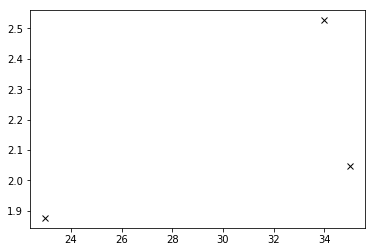

In [271]:
## create subset size for the trained data
sub = ma.ceil(perc*N)
## create fake data for model
noiseSize = 0.05

## define X values (integers from 20 to N+20)
X_all = np.arange(20,20+N+1,1)
## take sample for training
x_train = np.random.randint(20,20+N+1,sub)
x_train = x_train.reshape(-1,1)
x_train = x_train.astype(float)
y_train = np.sin(12*x_train) + 0.66*np.cos(25*x_train)  + np.random.randn(sub,1)*noiseSize + 3

## plot distribution of selected sensors
plt.plot(x_train, y_train, 'kx')

In [272]:
## build model
kernel = gpflow.kernels.RBF(1, active_dims=[0], lengthscales=1.0)
## build model
m = gpflow.models.GPR(x_train, y_train, kern=kernel)
m.likelihood.variance = 0.01

## view 
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/lengthscales,Parameter,None,+ve,True,(),True,1.0
GPR/kern/variance,Parameter,None,+ve,True,(),True,1.0
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,0.01


In [273]:
gpflow.train.ScipyOptimizer().minimize(m)
print(m.as_pandas_table())

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 3.398231
  Number of iterations: 31
  Number of functions evaluations: 42


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 3.398231
  Number of iterations: 31
  Number of functions evaluations: 42


                             class prior transform  trainable shape  \
GPR/kern/lengthscales    Parameter  None       +ve       True    ()   
GPR/kern/variance        Parameter  None       +ve       True    ()   
GPR/likelihood/variance  Parameter  None       +ve       True    ()   

                         fixed_shape                value  
GPR/kern/lengthscales           True    826.0590084529374  
GPR/kern/variance               True   4.5809846002726555  
GPR/likelihood/variance         True  0.11354623675206747  


In [274]:
## example: thought exercise
## 5 sensor locations: S = [4,5,6,7,8]
## total number of sensors to find: k = 2
## for each iteration (1:k):
    ## for each possible sensor location (y) not in A (S):
        ## calculate: corr(y)^2 - corr(yA)*np.linalg.inv(corr(AA))*corr(Ay) / corr(y)^2 - corr(ynA)*np.linalg.inv(corr(nAA))*corr(nAy)
    ## select max(store_val)
    ## append y to A

    
## selected sensors (indices)
A = np.array([],dtype=int)
## number of sensors to find
k = k
## define x_new as the new points not used for training
x_new = np.setdiff1d(X_all, x_train)
x_new = x_new.reshape(-1,1)
## define S as the incides of x_new
S = np.arange(0,x_new.shape[0]).reshape(x_new.shape[0],1)    

In [275]:
## x is np.array or single value
def generate_cov_mat(x):
    if not isinstance(x, np.ndarray):
        x = np.array(x).reshape(-1,1)
    ## select the 2nd object and bring up one dimension
    cov_mat = m.predict_f_full_cov(x)[1][0,:,:]
    return(cov_mat)

In [276]:
## WORKS ONLY FOR 1-D DATA
def plot_as_you_go(m, X_all, j, x_star, x_train, y_train, var_plot, X):
    
    ## where:
    ## m = model object
    ## x_all = all values of X
    ## j = iteration of sensor being picked
    ## x_star = best sensors picked so far
    ## x_train = x training data
    ## y_train = y training data
    ## var_plot = variance of the measurements (calc_1)
    ## X = the rest of the sample space (potential site points)
    
    ## true underlying function: dashed line
    ## mean: green line
    ## shade: sd
    ## training points: black dots
    ## selected sensor points: pink triangles
    
    ## so the footballs should be based on numerator, should match predicted variance in very beginning.
    
    ## define entire range of X
    #xx = np.linspace(0, N, N+1)[:,None]
    N = X.shape[0]
    xx = X_all
    ## actual function for entire range of X
    yy = np.sin(12*xx) + 0.66*np.cos(25*xx)  + np.random.randn(N,1)*noiseSize + 3
    
    ## predict values for entire range of X
    mean, var = m.predict_y(xx)
    plt.figure(figsize=(12, 6))
    
    ## display training data
    #mean_train, var_train = m.predict_y(x_train)
    #plt.plot(x_train, mean_train, 'ko', mew=2, alpha=0.55)
    
    ## display best sensors
    #mean_sensors, var_sensors = m.predict_y(x_star)
    ## plot the most recently added sensor darker than the others
    #plt.plot(x_star[j], mean_sensors[j], color='m', marker='v', mew=2, alpha=1.0)
    #plt.plot(x_star[0:j], mean_sensors[0:j], 'mv', mew=2, alpha=0.35)
    
    plt.plot(xx, yy, 'k--', alpha=0.5)
    plt.plot(xx, mean, 'g', lw=2)
    #plt.fill_between(xx[:,0], mean[:,0] - 2*np.sqrt(var_plot[:]), mean[:,0] + 2*np.sqrt(var_plot[:]), color='green', alpha=0.1)
    plt.xlim(-1, max(X))
    plt.title('Selected Sensors, N=' + str(N))
    plt.savefig('../figures/selected_sensors_' + str(N) + ' k=' + str(j))

In [277]:
def pick_best_sensors_krause(S, X, k, A, x_train, y_train, m=m, N=N, X_all=X_all, verbose=False):

    ## take out locations already in A before checks (iterations)
    S = S[np.isin(S, A, invert=True)]
    
    ## checks
    if k > S.shape[0]:
        print("error! k must be smaller than S")
        return
    if k/S.shape[0] > 0.25:
        print("Recommendation: k should be a significantly small fraction of S")
    
    ## print statements
    print("finding " + str(k) + " sensor locations of " + str(S.shape[0]) + " possible locations")
    
    ## next version: 
    ## add S + U
    
    ## later version:
    ## create function to generate model
    
    ## for each sensor to be added:
    for j in range(k):
        ## find the indices of coordinates not already in A to iterate through
        Y = S[np.isin(S, A, invert=True)]
        ## store the calculated value for each potential coordinate in order to take the max
        delta = np.array([])
        var_plot = np.array([])
        ## print iteration
        print("Starting iteration: " + str(j))
    
        for y in Y:
            ## define how many sensor sites already exist
            len_A = A.shape[0]
            #print("length of A: " + str(len_A))
            ## combine indices of y and A
            yA = np.append(np.array([y]), A, axis=0)
            #print("yA: " + str(yA))
            ## collect values of y and A using the indices
            yA_val = X[yA,:].reshape(yA.shape[0],X.shape[1])
            #print("yA_val: " + str(yA_val))
            
            ## define the rest of possible sites taking out y and A
            nyA = S[np.isin(S, yA, invert=True)]
            len_nA = nyA.shape[0]
            #print("length of nA: " + str(len_nA))
            ## define the indices of locations not in yA
            nyA = np.append(np.array([y]), nyA, axis=0)
            #print("nyA: " + str(nyA))
            ## collect values of y and nA using the indices
            nyA_val = X[nyA,:].reshape(nyA.shape[0],X.shape[1])
            #print("nyA_val: " + str(nyA_val))

            ## generate the covariance matrix:
            ##    y  A1  A2  ...
            ## y
            ## A1
            ## A2
            ## ...
            cov_mat_A = generate_cov_mat(yA_val)
            ## select y's covariance
            y_cov = cov_mat_A[:1,[0]]
            ## grab covariance values
            if len_A > 0:
                yA_cov = cov_mat_A[[0],1:len_A+1]
                Ay_cov = yA_cov.T
                AA_cov = cov_mat_A[1:len_A+1, 1:len_A+1]
                ## Mz = x, give M and x and solve for z
                AA_cov_inv = np.linalg.solve(AA_cov, Ay_cov)
                calc_1 = y_cov**2 - np.dot(yA_cov, AA_cov_inv)
                ## old code:
                #AA_cov = np.linalg.inv(cov_mat_A[1:len_A+1, 1:len_A+1])
                #calc_1 = y_cov**2 - np.dot(np.dot(yA_cov, AA_cov), Ay_cov)
            ## if A is empty: ignore the 2nd part of the calculation
            else:
                calc_1 = y_cov**2
            
            cov_mat_nA = generate_cov_mat(nyA_val)
            #print("cov_mat_nA: ")
            #print(cov_mat_nA)
            nyA_cov = cov_mat_nA[[0],1:len_nA+1]
            #print("nyA_cov: ")
            #print(nyA_cov)
            nAy_cov = nyA_cov.T
            nAA_cov = cov_mat_nA[1:len_nA+1, 1:len_nA+1]
            #print("nAA_cov: ")
            #print(nAA_cov)
            ## Mz = x, give M and x and solve for z
            nAA_cov_inv = np.linalg.solve(nAA_cov, nAy_cov)
            calc_2 = y_cov**2 - np.dot(nyA_cov, nAA_cov_inv)
            ## old code:
            #nAA_cov = np.linalg.inv(cov_mat_nA[1:len_nA+1, 1:len_nA+1])
            #calc_2 = y_cov**2 - np.dot(np.dot(nyA_cov, nAA_cov), nAy_cov)
            
            value = calc_1 / calc_2
            delta = np.append(delta, value)
            
            var_plot = np.append(var_plot, calc_1)
            
        ## find the index with the largest delta
        y_star = np.array(Y[np.argmax(delta)])
        ## append to A as a new sensor site
        A = np.append(A, y_star)
        
        ## generate plot for each iteration
        plot_as_you_go(m, X_all=X_all, j=j-1, x_star=X[A,:], x_train=x_train, y_train=y_train, var_plot=var_plot, X=Y.reshape(Y.shape[0],1))
        
        if verbose == True:
            #print(Y)
            #print(delta)
            print("Max value: " + str(np.amax(delta)))
            print("Picking sensor site: " + str(y_star))
    
    A_sites = X[A,:]
    return(A_sites, var_plot)

In [278]:
#print(S)
#print(x_new)
print(x_train)
print(N)
print(max(x_train))

[[23.]
 [34.]
 [35.]]
25
[35.]


In [280]:
best_sensors, var_plot = pick_best_sensors_krause(S=S, X=x_new, k=k, A=A, x_train=x_train, y_train=y_train, m=m, N=N, X_all=X_all, verbose=False)
print(best_sensors)
print(var_plot)

finding 3 sensor locations of 23 possible locations
Starting iteration: 0


ValueError: Cannot feed value of shape (26,) for Tensor 'autoflow/GPR/predict_y_48/Placeholder:0', which has shape '(?, ?)'

In [221]:
print(np.sqrt(var_plot))

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan]


/Users/adrianna/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


In [ ]:
## Original plot
## WORKS ONLY FOR 1-D DATA
def plot(m, N):
    ## true underlying function: dashed line
    ## mean: green line
    ## shade: sd
    ## training points: black dots
    ## selected sensor points: red triangles
    xx = np.linspace(0, N, N+1)[:,None]
    ## actual function
    yy = np.sin(12*xx) + 0.66*np.cos(25*xx)  + np.random.randn(N+1,1)*noiseSize + 3
    ## predict values
    mean, var = m.predict_y(xx)
    plt.figure(figsize=(12, 6))
    
    mean_train, var_train = m.predict_y(x_train)
    plt.plot(x_train, mean_train, 'ko', mew=2)
    
    mean_sensors, var_sensors = m.predict_y(best_sensors)
    plt.plot(best_sensors, mean_sensors, 'rv', mew=2)
    
    plt.plot(xx, yy, 'k--', alpha=0.5)
    plt.plot(xx, mean, 'g', lw=2)
    plt.fill_between(xx[:,0], mean[:,0] - 2*np.sqrt(var[:,0]), mean[:,0] + 2*np.sqrt(var[:,0]), color='green', alpha=0.1)
    plt.xlim(0, N)
    plt.title('Selected Sensors, N=' + str(N))
    plt.savefig('../figures/selected_sensors_' + str(N))
plot(m, N)

In [ ]:
#print(x_new.shape[1])
#print(x_new[0:5,:].reshape(5,1))
## combine indices of y and A
#yA = np.append(np.array([y]), A, axis=0)
## collect values of y and A using the indices
#yA_val = X[yA,:].reshape(yA.shape[0],X.shape[1])

#print(m.as_pandas_table())
#cov_mat_A = generate_cov_mat(x_new[0:5,:].reshape(5,1))
#print(cov_mat_A)

#m.likelihood.variance = 0.01
#print(m.as_pandas_table())
#cov_mat_A = generate_cov_mat(x_new[0:5,:].reshape(5,1))
#print(cov_mat_A)

## Try, artificially: (i) putting the input locations *very* close together;
## and (ii) increasing the correlation lengths.
## Keep the likelihood variance zero while you're at it.
## Could you extract the eigenvalues of the matrix that's causing a problem and list them?
## How small is the smallest eigenvalue?

In [39]:
x_train = np.array([[0,.00000001,.00000002,.00000003], [0,.00000002,.00000003,.00000001]]).reshape(4,2)
y_train = np.array([1.3, 2.4, 3.6, 1.0]).reshape(4,1)

## build model
kernel = gpflow.kernels.RBF(2, active_dims=[0,1], lengthscales=1.0)

## build model
m = gpflow.models.GPR(x_train, y_train, kern=kernel)
m.likelihood.variance = 0.01

gpflow.train.ScipyOptimizer().minimize(m)
print(m.as_pandas_table())

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 7.599100
  Number of iterations: 17
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 7.599100
  Number of iterations: 17
  Number of functions evaluations: 18


                             class prior transform  trainable shape  \
GPR/kern/lengthscales    Parameter  None       +ve       True    ()   
GPR/kern/variance        Parameter  None       +ve       True    ()   
GPR/likelihood/variance  Parameter  None       +ve       True    ()   

                         fixed_shape               value  
GPR/kern/lengthscales           True  1.0000000000000304  
GPR/kern/variance               True   3.956615773239524  
GPR/likelihood/variance         True  1.3958283825296467  


In [ ]:
#m.kern.lengthscales = 5
#m.kern.variance = 0
#m.likelihood.variance = 0
#print(m.as_pandas_table())

nyA_val = np.array([[0,.00000001,.00000002,.00000002], [0,.00000002,.00000003,.00000003]]).reshape(4,2)
#np.array([[0,.00000001,.00000002,.00000003], [0.00000003, 0.00000002, 0.00000000, 0]]).reshape(4,2)
cov_mat_nA = generate_cov_mat(nyA_val)
print(cov_mat_nA)
print(np.linalg.det(cov_mat_nA))
eig_val = np.linalg.eig(cov_mat_nA)
eig_val = eig_val[0]
print(eig_val.shape)
print(np.amin(eig_val))

In [ ]:
## fake data
## random int X and NO2 concentration Y works!
#X = np.random.randint(50, size=(20, 2)).astype(float)
## so does this...
#X = np.random.normal(size=(20,2))
#print(X.shape)
#print(X)
#dta = pd.read_csv("../data/kcl_london_model_data_winter_collapsed.csv", sep=',') 
#y = dta.loc[:,'nox'].values
#y = y.reshape(-1,1)

In [281]:
## aggregated over time
dta = pd.read_csv("../data/kcl_london_model_data_winter_collapsed.csv", sep=',') 
print(dta.shape)
params = ['latitude', 'longitude']

#dta = pd.read_csv("../data/kcl_london_model_data_winter_agg_time.csv", sep=',')
#print(dta.shape)
#params = ['latitude', 'longitude', 'year']

(230, 6)


In [282]:
print(dta.shape[0])
print(dta[params].drop_duplicates().shape[0])
dta = dta.drop_duplicates(params)
print(dta.shape)
#print(X.shape)
#unique_elements = np.unique(X)
#print(unique_elements[0:5])

230
212
(212, 6)


In [283]:
X = dta[params].values
print(X.shape)
## rescale lat/long and year data
## scaling the data causes the determinant to be 0 for the matrix
#X = feature_scaler.fit_transform(X)
y = dta.loc[:,'nox'].values
y = y.reshape(-1,1)
print(y.shape)

(212, 2)
(212, 1)


In [284]:
## set max number
N = 212
## set number of sensor locations to find
k = 5
## set percent of N to train on
perc = .10
#perc = .75

In [285]:
## subset to the trained data
sub = ma.ceil(perc*N)
print(sub)

22


In [286]:
## take the first sub coordinates for training
x_samps = np.arange(0,sub)
print(x_samps)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]


In [164]:
#print(X[x_samps,:])

In [287]:
## take sample for training
#x_samps = np.random.randint(X.shape[0], size=sub)

x_train = X[x_samps,:]
y_train = y[x_samps,:]
## standardize y-values
y_train = feature_scaler.fit_transform(y_train)

print(x_train.shape)
print(y_train.shape)

(22, 2)
(22, 1)


In [288]:
## build model
kernel = gpflow.kernels.RBF(2, active_dims=[0,1], lengthscales=1.0)
#kernel = gpflow.kernels.RBF(2, active_dims=[0,1], lengthscales=1.0) *\
#            gpflow.kernels.RBF(1 , active_dims=[2], lengthscales=0.1)

## build model
m = gpflow.models.GPR(x_train, y_train, kern=kernel)
m.likelihood.variance = 0.01

## could put bounds on likelihood variance to never be below or equal to 0.


## view 
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/lengthscales,Parameter,None,+ve,True,(),True,1.0
GPR/kern/variance,Parameter,None,+ve,True,(),True,1.0
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,0.01


In [289]:
## Run Model
## Marginal Liklihood Maximization
## picks the most simple model that picks the data the best
gpflow.train.ScipyOptimizer().minimize(m)
print(m.as_pandas_table())

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 24.281726
  Number of iterations: 39
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 24.281726
  Number of iterations: 39
  Number of functions evaluations: 58


                             class prior transform  trainable shape  \
GPR/kern/lengthscales    Parameter  None       +ve       True    ()   
GPR/kern/variance        Parameter  None       +ve       True    ()   
GPR/likelihood/variance  Parameter  None       +ve       True    ()   

                         fixed_shape                 value  
GPR/kern/lengthscales           True  0.041672003238773805  
GPR/kern/variance               True    0.8373748065039799  
GPR/likelihood/variance         True   0.10317750005748468  


In [292]:
## define x-values not used for training
## iterate all of X
#X_iter = np.arange(0,X.shape[0])
## take out the iters already used for training
#x_new = np.setdiff1d(X_iter, x_samps)
#sub+2+N+1
x_new_samps = np.arange(sub+1,212)
#x_new_samps = np.arange(sub+20, sub+30+20)
print(x_new_samps)
## randomly select new iterations from the list
#x_new_samps = np.random.choice(x_new, N-sub, replace=False)
#print(x_samps)
#print(x_new_samps)
x_new = X[x_new_samps,:]
print(x_new.shape)
print(x_new[0:5])
#print(x_samps)

[ 23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40
  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58
  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94
  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166
 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184
 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202
 203 204 205 206 207 208 209 210 211]
(189, 2)
[[51.52236671 -0.1547    ]
 [51.52250936 -0.15462215]
 [51.52254    -0.15459   ]
 [51.51392874 -0.1527927 ]
 [51.35865961 -0.14972395]]


In [293]:
## selected sensors (indices)
A = np.array([],dtype=int)
## number of sensors to find
k = k
## define S as the incides of x_new
S = np.arange(0,x_new.shape[0]).reshape(x_new.shape[0],1) 

In [294]:
## x is np.array or single value
def generate_cov_mat(x):
    if not isinstance(x, np.ndarray):
        x = np.array(x).reshape(-1,1)
    cov_mat = m.predict_f_full_cov(x)[1][0,:,:] #+ (identity * likelihood variance)
    eig_val = np.linalg.eigvals(cov_mat)
    #print(eig_val)
    #eig_val = eig_val[0]
    #print(np.amin(eig_val))
    return(cov_mat)

In [295]:
from scipy.linalg import det

In [296]:
print(x_new.shape)
#print(X[0,:])
m.likelihood.variance = 0.50

(189, 2)


In [297]:
test = np.array([[1,2,3,4], [4,5,2,-1]]).reshape(4,2)
print(np.amin(test))

-1


In [299]:
def pick_best_sensors_krause(S, X, k, A, verbose=False):

    ## take out locations already in A before checks
    S = S[np.isin(S, A, invert=True)]
    
    ## collect determinants
    det = np.array([])
    
    ## checks
    if k > S.shape[0]:
        print("error! k must be smaller than S")
        return
    if k/S.shape[0] > 0.25:
        print("Recommendation: k should be a significantly small fraction of S")
    
    ## print statements
    print("finding " + str(k) + " sensor locations of " + str(S.shape[0]) + " possible locations")
    
    ## next version: 
    ## add S + U
    
    ## later version:
    ## create function to generate model
    
    ## add order of points selected
    ## generate plots as it selects sensors 
    ## so the footballs should be based on numerator, should match predicted variance in very beginning.
    
    ## for each sensor to be added:
    for j in range(k):
        ## find the indices of coordinates not already in A to iterate through
        Y = S[np.isin(S, A, invert=True)]
        ## store the calculated value for each potential coordinate in order to take the max
        delta = np.array([])
        var_plot = np.array([])
        ## print iteration
        print("Starting iteration: " + str(j))
    
        for y in Y:
            ## define how many sensor sites already exist
            len_A = A.shape[0]
            ## combine indices of y and A
            yA = np.append(np.array([y]), A, axis=0)
            ## collect values of y and A using the indices
            yA_val = X[yA,:].reshape(yA.shape[0],X.shape[1])
            
            ## define the rest of possible sites taking out y and A
            nyA = S[np.isin(S, yA, invert=True)]
            len_nA = nyA.shape[0]
            ## define the indices of locations not in yA
            nyA = np.append(np.array([y]), nyA, axis=0)
            ## collect values of y and nA using the indices
            nyA_val = X[nyA,:].reshape(nyA.shape[0],X.shape[1])

            ## generate the covariance matrix:
            ##    y  A1  A2  ...
            ## y
            ## A1
            ## A2
            ## ...
            cov_mat_A = generate_cov_mat(yA_val)
            ## select y's covariance
            y_cov = cov_mat_A[:1,[0]]
            ## grab covariance values
            if len_A > 0:
                yA_cov = cov_mat_A[[0],1:len_A+1]
                Ay_cov = yA_cov.T
                AA_cov = cov_mat_A[1:len_A+1, 1:len_A+1]
                ## Mz = x, give M and x and solve for z
                AA_cov_inv = np.linalg.solve(AA_cov, Ay_cov)
                calc_1 = y_cov**2 - np.dot(yA_cov, AA_cov_inv)
                ## old code:
                #AA_cov = np.linalg.inv(cov_mat_A[1:len_A+1, 1:len_A+1])
                #calc_1 = y_cov**2 - np.dot(np.dot(yA_cov, AA_cov), Ay_cov)
            ## if A is empty: ignore the 2nd part of the calculation
            else:
                calc_1 = y_cov**2
            
            cov_mat_nA = generate_cov_mat(nyA_val)
            nyA_cov = cov_mat_nA[[0],1:len_nA+1]
            nAy_cov = nyA_cov.T
            nAA_cov = cov_mat_nA[1:len_nA+1, 1:len_nA+1]
            ## Mz = x, give M and x and solve for z
            #print(nAA_cov)
            nAA_cov_inv = np.linalg.solve(nAA_cov, nAy_cov)
            calc_2 = y_cov**2 - np.dot(nyA_cov, nAA_cov_inv)
            ## old code:
            #nAA_cov = np.linalg.inv(cov_mat_nA[1:len_nA+1, 1:len_nA+1])
            #calc_2 = y_cov**2 - np.dot(np.dot(nyA_cov, nAA_cov), nAy_cov)
            
            value = calc_1 / calc_2
            delta = np.append(delta, value)

        ## find the index with the largest delta
        y_star = np.array(Y[np.argmax(delta)])
        ## append to A as a new sensor site
        A = np.append(A, y_star)
        
        if verbose == True:
            #print(Y)
            #print(delta)
            print("Max value: " + str(np.amax(delta)))
            print("Picking sensor site: " + str(y_star))
    
    A_sites = X[A,:]
    return(A_sites)

In [195]:
#m.likelihood.variance = 10.0

In [300]:
#print(S.shape)
#print(x_new.shape)
best_sensors= pick_best_sensors_krause(S=S, X=x_new, k=k, A=A, verbose=False)
#print(best_sensors)
#print(var_plot)

finding 5 sensor locations of 189 possible locations
Starting iteration: 0
Starting iteration: 1
Starting iteration: 2
Starting iteration: 3
Starting iteration: 4


In [301]:
print(best_sensors)

[[ 5.15522640e+01 -4.02779000e-01]
 [ 5.16686433e+01 -2.20072056e-02]
 [ 5.15207875e+01  2.05460706e-01]
 [ 5.15884170e+01 -3.62989000e-01]
 [ 5.16173270e+01 -2.98775000e-01]]
